# Logistic regression: The Zero detector

We will again solve the MNIST handwritten image recognition problem.

In [52]:
#Common imports
import numpy as np
from pprint import pprint 

#to make this notebook's output stable across runs
np.random.seed(42)

#Sklearn specfic imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

#scipy 
from scipy.stats import loguniform

#To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))


In [2]:
# Ignore all warning by sklearn
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

# Handwritten Digit Classification

In [3]:
# get data
from sklearn.datasets import fetch_openml

X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True) 

In [4]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()

## Visualisation

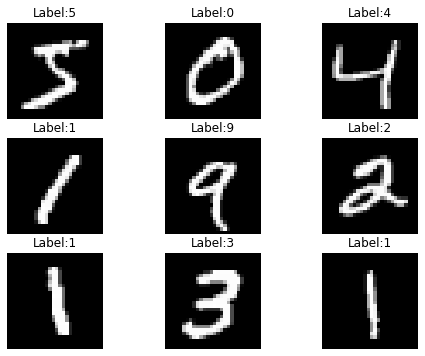

In [5]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Label:{0}'.format(str(y[index + j])))
        ax[i, j].set_axis_off()

## Pre-Processing

* Unlike perceptron, where scaling is optional, sigmoid requires scaling between 0 and 1
* Do not apply mean centering as it removes zeros from the data. Zeros should be kept as zeros in the data.
* we are not using pipeline, since there is just the one preprocessing step.

In [6]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Data Splitting

In [7]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Checking for imbalance

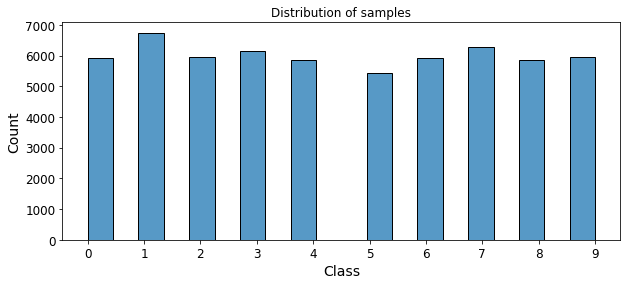

In [8]:
plt.figure(figsize=(10,4))
sns.histplot(data = np.int8(y_train), binwidth = 0.45, bins = 11)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## Binary classifcation: 0-detector

In [9]:
# Initialize new variable names with all 1
y_train_0 = np.zeros((len(y_train)))
y_test_0 =  np.zeros((len(y_test)))

#find indices of the digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1

indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

#### Sanity check

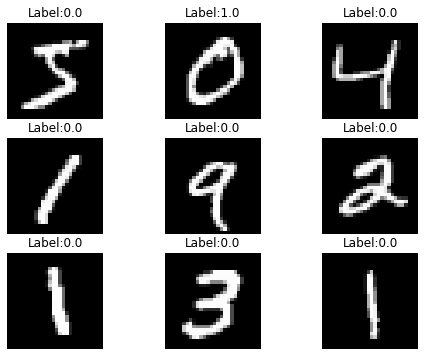

In [10]:

num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Label:{0}'.format(str(y_train_0[index + j])))
        ax[i, j].set_axis_off()

In [11]:
print(np.where(y_train=='0'))
print(np.where(y_train_0==1))

(array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64),)
(array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64),)


### Baseline Model


Let's quickly construct a baseline model witht he following rule

1. Count the number of samples per class
2. The model always outputs the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.

In [12]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == 0)[0])
print(num_pos, num_neg)

5923 54077


In [13]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(x_train, y_train_0)
print('Training accuracy:{0:0.2f}'.format(base_clf.score(x_train, y_train_0)))
print('Testing accuracy:{0:0.2f}'.format(base_clf.score(x_test, y_test_0)))
print('Score: ', base_clf.score(x_train, y_train_0))

Training accuracy:0.90
Testing accuracy:0.90
Score:  0.9012833333333333


### Logistic Regression model with `SGDClassifier`

#### Training without regularisation

In [14]:
bin_sgd_clf = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)

Loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf.fit(x_train, y_train_0)
    y_pred = bin_sgd_clf.predict_proba(x_train)
    Loss.append(log_loss(y_train_0, y_pred))

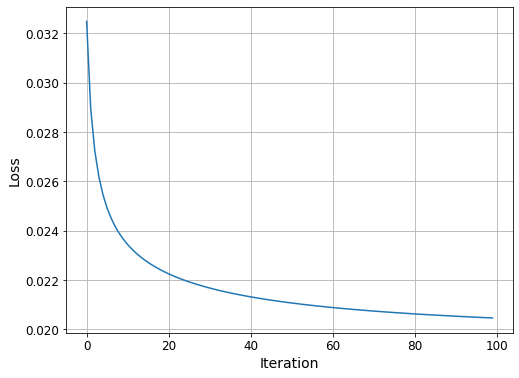

In [15]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [16]:
print('Training accuracy:{0:0.2f}'.format(bin_sgd_clf.score(x_train, y_train_0)))
print('Testing accuracy:{0:0.2f}'.format(bin_sgd_clf.score(x_test, y_test_0)))

Training accuracy:0.99
Testing accuracy:0.99


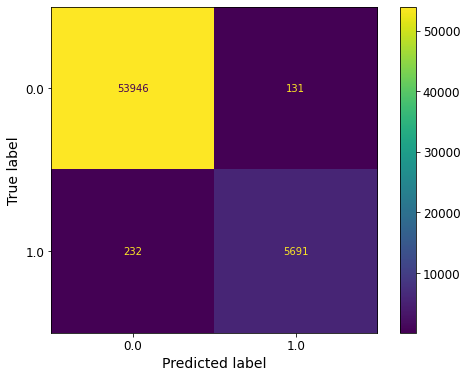

In [17]:
y_hat_train_0 = bin_sgd_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [18]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



#### Training with cross_validation

In [19]:
estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=100,
                            warm_start=False,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)

In [20]:
cv_bin_clf = cross_validate(estimator, x_train, y_train_0, cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            return_train_score=True,
                            return_estimator=True)

pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([1.14403105, 1.11995268, 1.1445415 , 1.26419497, 1.09598875]),
 'score_time': array([0.03196669, 0.03200412, 0.03196311, 0.03199983, 0.03200269]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.9

In [21]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
print('Dimension of weights w: {0}'.format(weights.shape))
print('Bias: {0}'.format(bias))

Dimension of weights w: (1, 784)
Bias: [-4.89282893]


<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

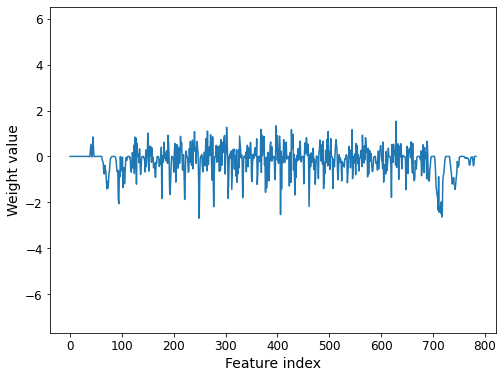

In [22]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid

* a lot of weights seems to have zero values. Let's find out how many

In [23]:
num_zero_w = weights.shape[1] - np.count_nonzero(weights)
print('Number of weights with value zero: %f' %num_zero_w)

Number of weights with value zero: 67.000000


* As such, regularisation is not required since there aren't any weight vectors which blow up. BUt we will go ahead for the purpose of demonstration.

#### Training with regularisation

In [24]:
bin_clf_sgd_l2 = SGDClassifier(loss='log',
                                penalty = 'l2',
                                alpha=0.001,
                                max_iter=1,
                                eta0=0.01,
                                warm_start=True,
                                learning_rate='constant',
                                random_state=1729)

Loss = []
iterations = 100
for i in range(iterations):
    bin_clf_sgd_l2.fit(x_train, y_train_0)
    y_pred = bin_clf_sgd_l2.predict_proba(x_train)
    Loss.append(log_loss(y_train_0, y_pred))

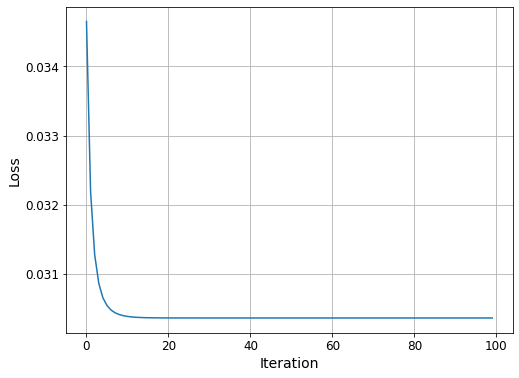

In [25]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [26]:
weights = bin_clf_sgd_l2.coef_
bias = bin_clf_sgd_l2.intercept_
print('Dimension of weights w: {0}'.format(weights.shape))
print('Bias: {0}'.format(bias)) 

Dimension of weights w: (1, 784)
Bias: [-4.43002876]


<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

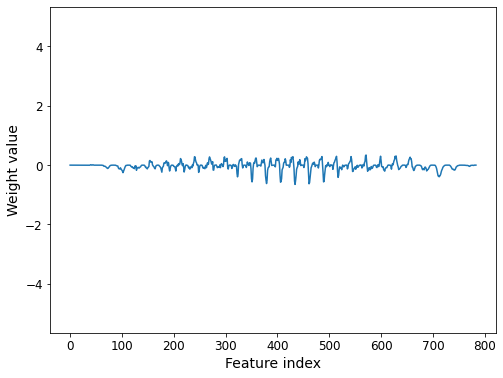

In [27]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid

In [28]:
num_zero_w = weights.shape[1] - np.count_nonzero(weights)
print('Number of weights with value zero: %f' %num_zero_w)

Number of weights with value zero: 67.000000


In [29]:
print('Training accuracy %.2f' %bin_clf_sgd_l2.score(x_train, y_train_0))
print('Testing accuracy %.2f' %bin_clf_sgd_l2.score(x_test, y_test_0))

Training accuracy 0.99
Testing accuracy 0.99


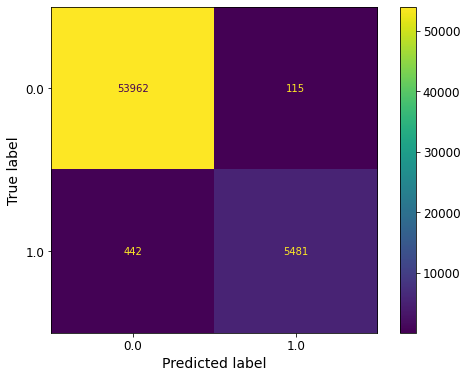

In [30]:
y_hat_train_0 = bin_clf_sgd_l2.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [31]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



Let's display a few images and their prediction

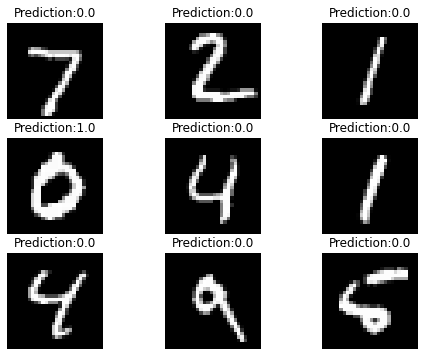

In [32]:
y_hat_test_0 = bin_clf_sgd_l2.predict(x_test)
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(x_test[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index + j])))
        ax[i, j].set_axis_off()

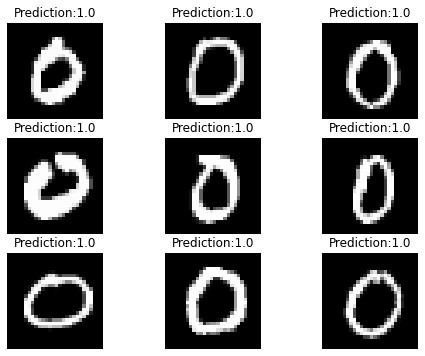

In [33]:
indx_0 = np.where(y_test_0 == 1)

zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]

num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(zeroImgs[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Prediction:{0}'.format(str(zeroLabls[index + j])))
        ax[i, j].set_axis_off()

#### Hyper parameter tuning

In [34]:
# Learning rate values to try
lr_grid = loguniform(1e-2, 1e-1)

estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)

In [35]:
scores = RandomizedSearchCV(estimator,
                            param_distributions={'eta0': lr_grid},
                            cv = 5,
                            n_iter = 5,
                            refit = 'f1')

In [36]:
scores.fit(x_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028C0E135240>},
                   refit='f1')

In [37]:
pprint(scores.cv_results_)

{'mean_fit_time': array([0.39668241, 0.33406005, 0.34944892, 0.35022621, 0.39345675]),
 'mean_score_time': array([0.02568798, 0.01672115, 0.01987662, 0.02143126, 0.02338071]),
 'mean_test_score': array([0.99095   , 0.9883    , 0.98985   , 0.99031667, 0.99116667]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                   0.05395030966670228, 0.039687933304443715,
                   0.01432249371823025],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.02368863950364078},
            {'eta0': 0.08927180304353625},
            {'eta0': 0.05395030966670228},
            {'eta0': 0.039687933304443715},
            {'eta0': 0.01432249371823025}],
 'rank_test_score': array([2, 5, 4, 3, 1]),
 'split0_test_score': array([0.99008333, 0.98333333, 0.98708333, 0.98841667, 0.99041667]),
 'split1_test_score': array([0.99016667, 0.9895    , 0.98966667, 0.98966667, 0.99008333]),
 'split2

In [38]:
best_bin_clf = scores.best_estimator_

In [39]:
y_hat_train_best_0 = best_bin_clf.predict(x_train)

In [40]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



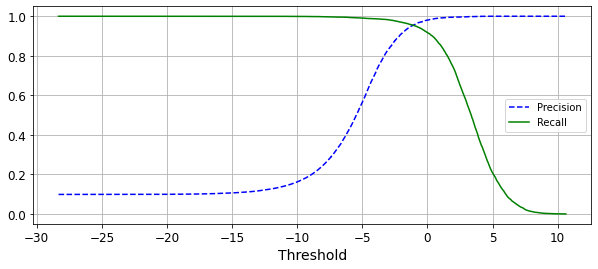

In [41]:
y_scores = best_bin_clf.decision_function(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.grid(True)
plt.legend()
plt.show()

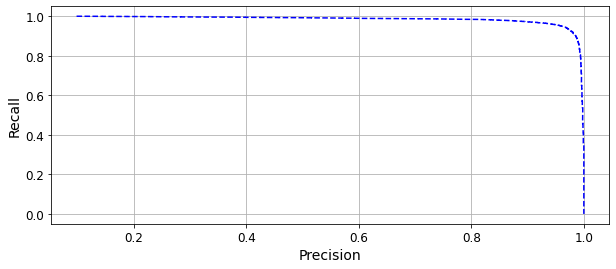

In [42]:
plt.figure(figsize=(10,4))
plt.plot(precisions[:-1], recalls[:-1], "b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

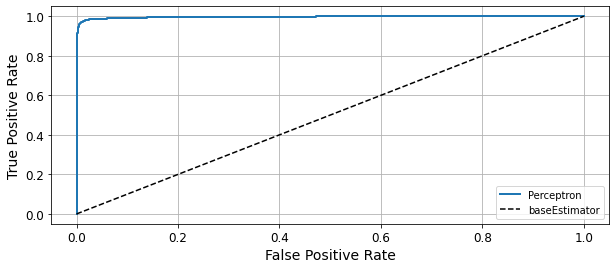

In [43]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label = 'Perceptron')
plt.plot([0, 1], [0,1], 'k--', label = 'baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [44]:
auc = roc_auc_score(y_train_0, y_scores)
print('AUC: %.3f' % auc)

AUC: 0.997


## Same model with `LogisticRegression`

###  Training without regularisation

* Set $C = \infty$

In [46]:
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729,
                                                                   solver='lbfgs',
                                                                   C = np.infty))

pipe_logit.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

#### Hyper parameter search

In [48]:
from sklearn.pipeline import Pipeline

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0, random_state=1729)

pipe = Pipeline(steps=[("scaler", scaler),
                        ("logistic", logreg)])

pipe_logit_cv = GridSearchCV(pipe,
                                param_grid={"logistic__C": grid_Cs},
                                scoring='f1')

pipe_logit_cv.fit(x_train, y_train_0)


GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [51]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [50]:
pipe_logit_cv.best_score_

0.9579654953103655

With `LogisticRegressionCV`

In [53]:
estimator = LogisticRegressionCV(cv =5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

###  Performance Evaluation

For 
* Logistic regression without regularisation
* Best logistic regression classifier found through `GridSearchCV`
* Best classifier found through `LogisticRegressionCV`

In [54]:
#Predictions

lr_y_hat_0 = pipe_logit.predict(x_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(x_test)
lr_cv_y_hat_0 = logit_cv.predict(x_test)

In [55]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

In [56]:
print(f"LogReg: Precision = {precision_lr}, recall = {recall_lr}")
print(f"GridSearch: Precision = {precision_lr_gs}, recall = {recall_lr_gs}")
print(f"LogRegCV: Precision = {precision_lr_cv}, recall = {recall_lr_cv}")

LogReg: Precision = 0.9515151515151515, recall = 0.9612244897959183
GridSearch: Precision = 0.9564336372847011, recall = 0.963265306122449
LogRegCV: Precision = 0.9546370967741935, recall = 0.9663265306122449


## Multiclass Logistic regresssion with SGD(OneVsAll)

In [57]:
estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)

pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)

In [58]:
Loss = []
iterations = 100
for i in range(iterations):
    pipe_sgd_ovr.fit(x_train, y_train)
    y_pred = pipe_sgd_ovr.predict_proba(x_train)
    Loss.append(log_loss(y_train, y_pred))

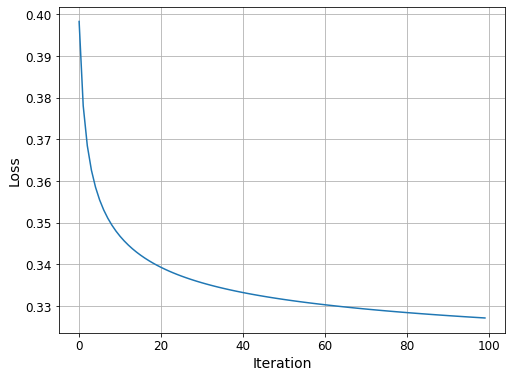

In [59]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [60]:
pipe_sgd_ovr[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=1729, warm_start=True)

In [61]:
y_hat = pipe_sgd_ovr.predict(x_test)

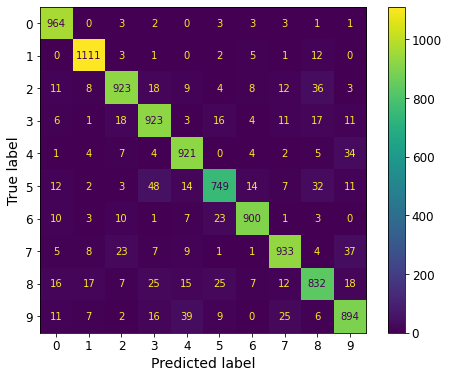

In [62]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [63]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



## Using Solvers

In [64]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(),
                                LogisticRegression(random_state=1729,
                                                    solver='lbfgs',
                                                    C = np.infty))

pipe_logit_ovr.fit(x_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

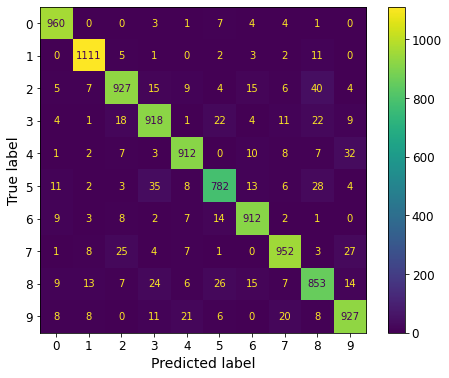

In [65]:
y_hat = pipe_logit_ovr.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [66]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000

